## Run state prediction on NACA0012 data
This is a tutorial on using the `StatePred` to predict the $200$-dimensional pressure vector $x$ across the surface of a [NACA0012 airfoil](https://en.wikipedia.org/wiki/NACA_airfoil) at varying angles of attack $t$. We will learn a Koopman matrix from given training data, valdiate and test the model on validation and test data, respectively, then use the learned model to predict unknown pressure vectors at new angles of attack.

In [1]:
from dlkoopman.state_pred import *
from dlkoopman import utils

### Load data

In [2]:
import pickle
with open('./data.pkl', 'rb') as f:
    data = pickle.load(f)

The resulting `data` dictionary has keys that are required by [`StatePredDataHandler`](https://galoisinc.github.io/dlkoopman/state_pred.html#dlkoopman.state_pred.StatePredDataHandler). The contents are:
- `'ttr': range(15)`. Angle of attack values used for training. Note that the training indexes must be in ascending order and should ideally be equally spaced.
- `'Xtr'` of shape `(15,200)`. Each row is the 200-dimensional pressure vector $x$ for the corresponding angle of attack (i.e. `Xtr[0]` corresponds to $x_0$).
- `'tva': [0.5,3.5,4.5,7.5,16,17,20]`, and `'tte': [1.5,2.5,5.5,6.5,15,18,19]`. Angle of attack values used for validating and testing the model, respectively. Note that these indexes can be anything, order and spacing is not important.
- `'Xva'` and `'Xte'`. Pressure vectors corresponding to `'tva'` and `'tte'` (i.e. `Xva[0]` corresponds to $x_{0.5}$, `Xte[-1]` corresponds to $x_{19}$, etc).

We'll now create a data handler. This has required arguments `Xtr` and `ttr`, since training data must be provided. Optionally, we can also provide validation and test data. 

In [3]:
dh = StatePredDataHandler(
    Xtr=data['Xtr'], ttr=data['ttr'],
    Xva=data['Xva'], tva=data['tva'],
    Xte=data['Xte'], tte=data['tte']
)

The following is an optional step used to seed the run. Since neural nets initialize their parameters randomly, setting the same random seed ensures reproducibility of results as long as the same `torch` version is used (we used `1.12.1`). If you do not get the exact same results as ours, don't worry, the basic aim of the tutorials is for you to understand how things work.

In [4]:
utils.set_seed(10)

### Create state predictor object
This is documented [here](https://galoisinc.github.io/dlkoopman/state_pred.html#dlkoopman.state_pred.StatePred).

In [5]:
sp = StatePred(
    dh = dh,
    rank = 6,
    encoded_size = 50
)

Log file = /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/log_nb2TP5vjwJLJ2FPBafKLwg.log


It creates an instance and prints the log file path (yours will be different).

The `rank` is $6$, i.e. the Koopman matrix will be of dimension $6\times6$ (for more on `rank`, see [here](https://arxiv.org/abs/2211.07561)). The encoded vector $y$ will be $50$-dimensional. Since by default `encoder_hidden_layers = [100]`, the autoencoder looks like:
<figure><center>
<img src="naca0012_ae_architecture.png" width=480/>
</center></figure>

### Training and testing
This uses all the default training settings, which can be found [here](https://galoisinc.github.io/dlkoopman/state_pred.html#dlkoopman.state_pred.StatePred.train_net).

In [6]:
sp.train_net()
sp.test_net()

100%|██████████| 500/500 [00:06<00:00, 76.61it/s]


### Visualizing results
Let's plot:
- The loss for the prediction task.
- The overall loss, which is a linear combination of different losses, and is optimized during training via gradient descent.
- The prediction average normalized absolute error (ANAE), which is a measure of the relative error between the original inputs and the finally predicted and decoded outputs.

The metrics are documented [here](https://galoisinc.github.io/dlkoopman/metrics.html).

Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_nb2TP5vjwJLJ2FPBafKLwg_pred_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_nb2TP5vjwJLJ2FPBafKLwg_total_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_nb2TP5vjwJLJ2FPBafKLwg_pred_anae.png


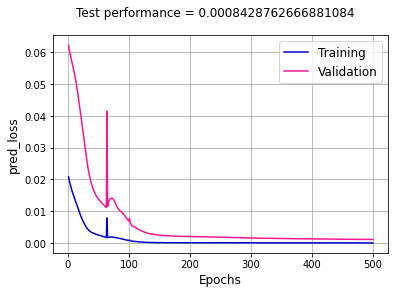

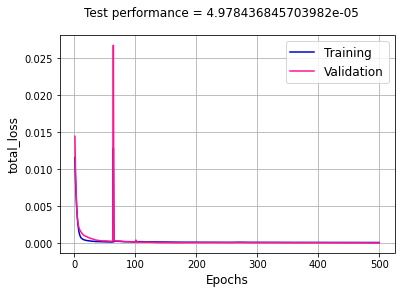

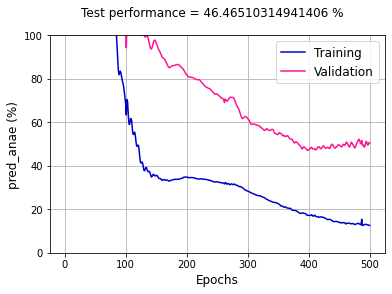

In [7]:
utils.plot_stats(sp, ['pred_loss', 'total_loss', 'pred_anae'])

(Your save paths will be different)

Despite a spike early on in training (potentially due to numerical instabilities), `loss` and `pred_loss` go down as expected and the final losses on test data are low. However, `pred_anae` on test data is $\sim46\%$, which isn't great, but also isn't surprising since we didn't optimize the training at all.

Let's see if we can do better.

### Optimizing
Let's tweak the settings and re-run.

  0%|          | 3/1000 [00:00<00:40, 24.38it/s]

Log file = /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/log_5rp8Yyp6UKzmwyzQ5NgWtK.log


100%|██████████| 1000/1000 [00:41<00:00, 24.18it/s]


Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_5rp8Yyp6UKzmwyzQ5NgWtK_pred_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_5rp8Yyp6UKzmwyzQ5NgWtK_total_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_5rp8Yyp6UKzmwyzQ5NgWtK_pred_anae.png


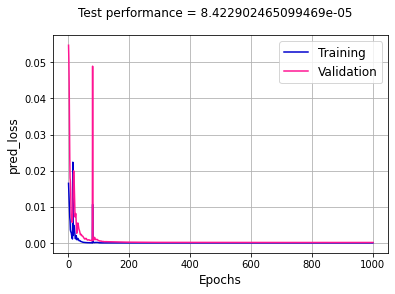

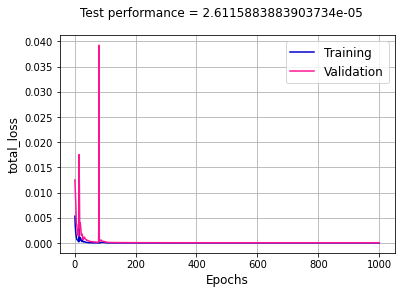

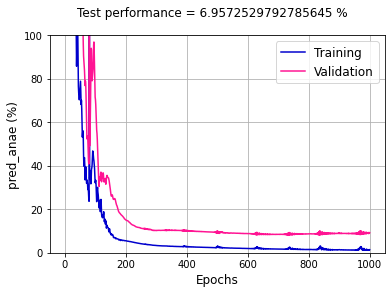

In [8]:
utils.set_seed(10)

sp = StatePred(
    dh = dh,
    rank = 6,
    encoded_size = 500,
    encoder_hidden_layers = [1000,500]
)

sp.train_net(
    numepochs = 1000,
    decoder_loss_weight = 0.1,
    Kreg = 0.,
    clip_grad_value = 2.
)

sp.test_net()

utils.plot_stats(sp, ['pred_loss', 'total_loss', 'pred_anae'])

The `pred_anae` on test data is now an impressive $6.95\%$, indicating that one can expect any predictions $x$ for some unknown $t$ to be within $7\%$ of the actual values.

### Improving run time
The above network might have taken close to a minute to train. Let's try stopping training early if the validation `pred_anae` does not improve for 50 epochs.

  0%|          | 3/1000 [00:00<00:35, 28.13it/s]

Log file = /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/log_78MjFcpRyWPShqbk65hYDu.log


 56%|█████▌    | 555/1000 [00:18<00:15, 29.39it/s]


Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_78MjFcpRyWPShqbk65hYDu_pred_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_78MjFcpRyWPShqbk65hYDu_total_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/state_pred_naca0012/plot_78MjFcpRyWPShqbk65hYDu_pred_anae.png


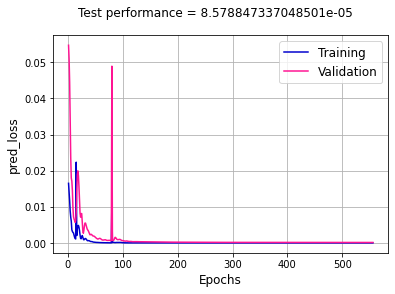

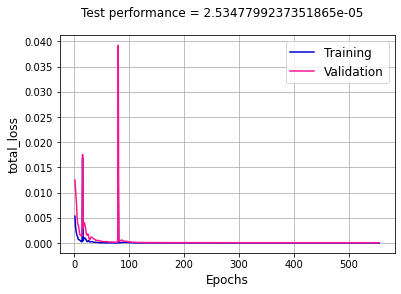

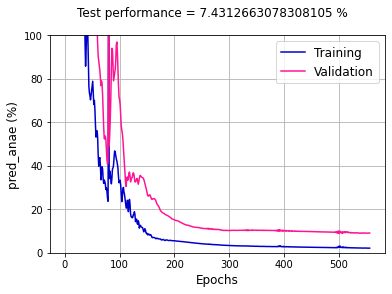

In [9]:
utils.set_seed(10)

sp = StatePred(
    dh = dh,
    rank = 6,
    encoded_size = 500,
    encoder_hidden_layers = [1000,500]
)

sp.train_net(
    numepochs = 1000,
    decoder_loss_weight = 0.1,
    Kreg = 0.,
    clip_grad_value = 2.,

    ## New settings
    early_stopping = 50,
    early_stopping_metric = 'pred_anae'
)

sp.test_net()

utils.plot_stats(sp, ['pred_loss', 'total_loss', 'pred_anae'])

Training is now faster, and stops after 555 epochs. The `pred_anae` on test data is slightly higher than before at $7.43\%$.

If you're wondering how we arrived at the input configurations in the above sections, check out the tutorial [`hyp_search.ipynb`](./hyp_search.ipynb).

### Unknown state predictions
Let's use the trained model to print predictions for $x_{3.75}$ and $x_{21}$, i.e. the unknown $200$-dimensional pressure vectors for angles of attack $3.75^{\circ}$ and $21^{\circ}$. Note that one of these values is in between the given data values $3.5$ and $4$, while the other is beyond the given data values. This demonstrates `StatePred`'s ability to perform *interpolation* and *extrapolation*.

In [10]:
sp.predict_new([3.75,21])

tensor([[ 2.9800e-01,  2.1239e-01,  1.8456e-01,  1.6356e-01,  1.4928e-01,
          1.3652e-01,  1.2209e-01,  1.1489e-01,  1.0724e-01,  9.9882e-02,
          9.2997e-02,  8.3977e-02,  7.8498e-02,  7.2773e-02,  6.6075e-02,
          5.9416e-02,  5.6149e-02,  5.1409e-02,  4.7045e-02,  4.3924e-02,
          3.8396e-02,  3.3760e-02,  2.9491e-02,  2.9445e-02,  2.1060e-02,
          2.2643e-02,  1.6566e-02,  1.2795e-02,  1.2286e-02,  8.1408e-03,
          3.8048e-03,  2.8320e-03, -1.6762e-03, -3.0922e-03, -7.2604e-03,
         -5.3711e-03, -9.5780e-03, -1.1859e-02, -1.5789e-02, -1.5730e-02,
         -2.1322e-02, -2.2409e-02, -2.0639e-02, -2.4832e-02, -2.6774e-02,
         -3.0384e-02, -3.3750e-02, -3.3789e-02, -3.4268e-02, -3.8729e-02,
         -3.8699e-02, -3.9703e-02, -4.4543e-02, -4.2319e-02, -4.2541e-02,
         -4.5359e-02, -4.5184e-02, -4.7451e-02, -4.8694e-02, -4.8315e-02,
         -4.7517e-02, -4.6338e-02, -4.7174e-02, -4.6365e-02, -4.5498e-02,
         -4.4083e-02, -4.0318e-02, -3.

### Checking the eigendecomposition
The eigendecomposition of the Koopman matrix characterizes the whole system, so let's check it out. The `Omega` attribute is a diagonal matrix containing the continuous index eigenvalues as its diagonal elements.

In [11]:
print('Eigenvalues:')
print(torch.diagonal(sp.Omega))

Eigenvalues:
tensor([ 0.0419+0.0000j, -0.0464+0.0826j, -0.0464-0.0826j, -0.5503+0.0000j,
        -0.1725+0.6959j, -0.1725-0.6959j], grad_fn=<DiagonalBackward0>)


or, after converting to discrete index eigenvalues `Lambda`:

In [12]:
Lambda = torch.exp(sp.Omega)
print('Discrete index eigenvalues:')
print(torch.diagonal(Lambda))

Discrete index eigenvalues:
tensor([1.0428+0.0000j, 0.9514+0.0788j, 0.9514-0.0788j, 0.5768+0.0000j,
        0.6459+0.5395j, 0.6459-0.5395j], grad_fn=<DiagonalBackward0>)


Notice that the dominant eigenvalue is $\sim1$, which ensures a stable system. Also note that there are 6 eigenvalues, since `rank = 6`.

### Changing configuration options
Although we generally do not recommend it, there are various configuration options that the user can change in [`config.py`](../../dlkoopman/config.py) if desired. These are documented [here](https://galoisinc.github.io/dlkoopman/config.html).